In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import sbi.utils as utils
from sbi.inference import infer

## Manual embedding

In [2]:
N = 200

def f1(x, y, theta):
    a = theta[0]
    b = theta[1]
    return a * x - b * x * y

def f2(x, y, theta):
    c = theta[2]
    d = theta[3]
    return -c * y + d * x * y

def LV_EE(N, Y0, theta):
    dt = 0.5
    H = np.zeros(N)
    P = np.zeros(N)
    H[0] = Y0[0]
    P[0] = Y0[1]
    for n in range(N-1):
        H[n+1] = H[n] + dt * f1(H[n], P[n], theta) + np.random.randn() * 10
        P[n+1] = P[n] + dt * f2(H[n], P[n], theta) + np.random.randn() * 10
    return H, P

def simulator(theta):
    H0 = 200
    P0 = 100

    H, P = LV_EE(N ,[H0, P0], np.array(theta))
    
    mean1 = H.mean()
    mean2 = P.mean()
    var1 = np.log(H.var())
    var2 = np.log(P.var())
    
    stats1 = np.array([mean1, mean2, var1, var2])
    
    autocor1 = np.correlate(H, H, mode="full")
    autocor1 = autocor1[len(autocor1)//2:] / np.max(np.abs(autocor1))
    
    autocor2 = np.correlate(P, P, mode="full")
    autocor2 = autocor1[len(autocor2)//2:] / np.max(np.abs(autocor2))
    
    cross_cor = np.correlate(H, P, mode="full")
    cross_cor = cross_cor[len(cross_cor)//2:] / np.max(np.abs(cross_cor))
        
    return np.concatenate([stats1, autocor1[1:5], autocor2[1:5], cross_cor[1:5]])

In [3]:
a=0.1
b=5e-5
c=0.04
d=b

theta = np.array([a, b, c, d])

observations = simulator(theta)
observations

array([1.41001534e+03, 3.20321597e+03, 1.53893084e+01, 1.62388180e+01,
       9.98367506e-01, 9.93555132e-01, 9.85652666e-01, 9.74807063e-01,
       2.47134154e-01, 2.21881269e-01, 1.98484844e-01, 1.76982062e-01])

In [4]:
num_dim = 4
prior = utils.BoxUniform(low=torch.zeros(num_dim), high=torch.ones(num_dim) * torch.tensor([0.5, 1e-4, 0.5, 1e-4]))

In [5]:
posterior = infer(simulator, prior, method='SNPE', num_simulations=1000)

/home/benoit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in double_scalars
  
/home/benoit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/benoit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/benoit/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/benoit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/home/benoit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
/home/benoit/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Neural network successfully converged after 153 epochs.


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

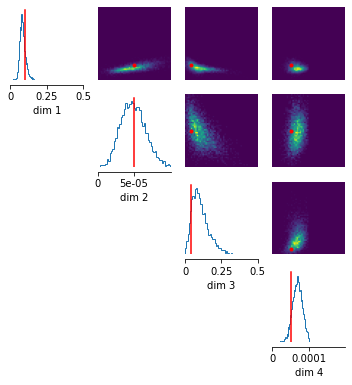

In [6]:
observation = simulator(theta)
samples = posterior.sample((5000,), x=observation)
log_probability = posterior.log_prob(samples, x=observation)
_ = utils.pairplot(samples,
                   limits=[[0,0.5],[0,1e-4],[0,0.5], [0, 2e-4]],
                   points=theta,
                   points_offdiag={'markersize': 6},
                   points_colors='r',
                   fig_size=(6,6))

## Learned embedding

In [7]:
import torch.nn as nn

embedding = nn.Sequential(
                nn.Conv1d(2, 16, kernel_size=5),
                nn.ReLU(),
                nn.Conv1d(16, 16, kernel_size=5),
                nn.ReLU(),
                nn.Flatten(),
                nn.Linear(3072, 20)
            )

In [8]:
def simulator_ts(theta):
    H0 = 200
    P0 = 100

    H, P = LV_EE(N ,[H0, P0], np.array(theta))
        
    return torch.tensor(np.concatenate([H.reshape(1, -1), P.reshape(1, -1)], axis=0)[None, :, :], dtype=torch.float)

In [9]:
from sbi import utils
from sbi import inference
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi

# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = prepare_for_sbi(simulator_ts, prior)

# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(model='maf', 
                                      embedding_net=embedding)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

# run the inference procedure on one round and 10000 simulated data points
theta_samples, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=10000)
density_estimator = inference.append_simulations(theta_samples, x).train()
posterior = inference.build_posterior(density_estimator)

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

/home/benoit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in double_scalars
  
/home/benoit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/benoit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


Neural network successfully converged after 49 epochs.


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

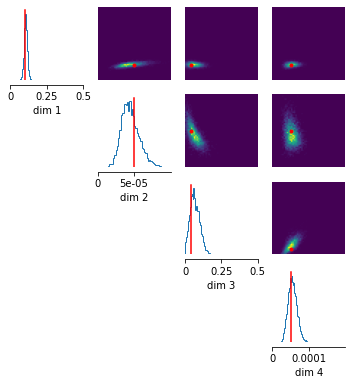

In [10]:
observation = simulator_ts(theta)
samples = posterior.sample((5000,), x=observation)
log_probability = posterior.log_prob(samples, x=observation)
_ = utils.pairplot(samples,
                   limits=[[0,0.5],[0,1e-4],[0,0.5], [0, 2e-4]],
                   points=theta,
                   points_offdiag={'markersize': 6},
                   points_colors='r',
                   fig_size=(6,6))